<a href="https://colab.research.google.com/github/mikhilg10/Hierarchical-Clustering/blob/master/Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
#import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd
import os
import sys
import warnings
import IPython.display as ipd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Ravdes DATA 
Feature extraction from the raw/uncategorised data availabe

In [4]:
ravdess_db = pd.DataFrame(columns=['path','source','actor', 'gender', 'emotion','emotion_lb'])
count = 0
data_path = '/content/drive/MyDrive/ML Project/RAVDES/audio_speech_actors_01-24'
#print(data_path)
dir_list = os.listdir(data_path)
dir_list.sort()
#print(dir_list).
for i in dir_list:
    #print(i)
    file_list = os.listdir(data_path + '/'+ i)
    for f in file_list:
        #print(f)
        nm = f.split('.')[0].split('-')
        path = data_path +'/'+ i + '/' + f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        source = "Ravdess"

        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"

        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1

        if nm[4] == '01':
            statement = 0
        else:
            statement = 1

        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1

        if emotion == 1:
            lb = "neutral"
        elif emotion == 2:
            lb = "calm"
        elif emotion == 3:
            lb = "happy"
        elif emotion == 4:
            lb = "sad"
        elif emotion == 5:
            lb = "angry"
        elif emotion == 6:
            lb = "fearful"
        elif emotion == 7:
            lb = "disgust"
        elif emotion == 8:
            lb = "surprised"
        else:
            lb = "none"

        ravdess_db.loc[count] = [path,source,actor, gender, emotion,lb]
        count += 1

        


####Processed Data
[Here](https://colab.research.google.com/drive/1c-MQBE7sQSJtrOPftzjGAP4biFSvFuJf?usp=sharing) link to the notebook

In [6]:
df = pd.read_csv("/content/drive/MyDrive/ML Project/final _data_with_six_emotions.csv")
df=df[['path','emotion']]
df.head()

,path,emotion
0,/content/drive/MyDrive/ML Project/Torrento/YAF...,disgust
1,/content/drive/MyDrive/ML Project/Torrento/YAF...,angry
2,/content/drive/MyDrive/ML Project/Torrento/YAF...,neutral
3,/content/drive/MyDrive/ML Project/Torrento/YAF...,sad
4,/content/drive/MyDrive/ML Project/Torrento/YAF...,sad


In [7]:
#Defining the X and Y for further processing
X=df['path']
Y_dash=df['emotion']

In [8]:
from sklearn.preprocessing import LabelEncoder
def prepare_targets(y_train):
	le = LabelEncoder()
	le.fit(y_train)
	y_train_enc = le.transform(y_train)
	
	return y_train_enc

Y=prepare_targets(Y_dash)

##**Visualization**

Text(0.5, 1.0, 'Log-frequency power spectogram')

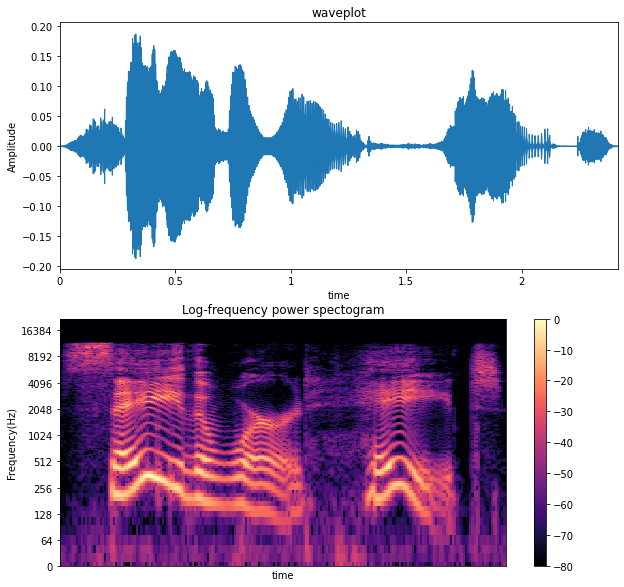

In [9]:
Fs = 44100;
data, rate = librosa.load(df['path'][0],sr = Fs)
# Finding the Short Time Fourier Transform  (STFT)
data_stft = librosa.stft(data)
#Conversion from amplitude to dB scale to visulaize spectrogram
data_stft_dB = librosa.amplitude_to_db(np.abs(data_stft), ref=np.max)
plt.figure(figsize=(10,10))
plt.subplot(211)
librosa.display.waveplot(data, sr = Fs)
plt.xlabel('time')
plt.ylabel('Amplitude')
plt.title('waveplot')
plt.subplot(212)
# log-frequency power spectogram
librosa.display.specshow(data_stft_dB, y_axis='log', sr=Fs)
plt.colorbar()
plt.xlabel('time')
plt.ylabel('Frequency(Hz)')
plt.title('Log-frequency power spectogram')


**Endpointing**

In [11]:
def endpoint(data, threshold):
    data_trim, index = librosa.effects.trim(data[Fs:], top_db=threshold)
    # Finding the Short Time Fourier Transform  (STFT)
    data_stft = librosa.stft(data_trim)
    #Conversion from amplitude to dB scale to visulaize spectrogram
    data_stft_dB = librosa.amplitude_to_db(np.abs(data_stft), ref=np.max)
    plt.figure(figsize=(10,10))
    plt.subplot(311)
    librosa.display.waveplot(data, sr = Fs)
    plt.xlabel('time')
    plt.ylabel('Amplitude')
    plt.title('waveform of original file')
    plt.subplot(312)
    librosa.display.waveplot(data_trim, sr = Fs)
    plt.xlabel('time')
    plt.ylabel('Amplitude')
    plt.title('waveform after silence removal')
    plt.subplot(313)
    # log-frequency power spectogram
    librosa.display.specshow(data_stft_dB, y_axis='log', sr=Fs)
    plt.colorbar()
    plt.xlabel('time')
    plt.ylabel('Frequency(Hz)')
    plt.title('Log-frequency power spectogram of trimmed file')
   
    return data_trim



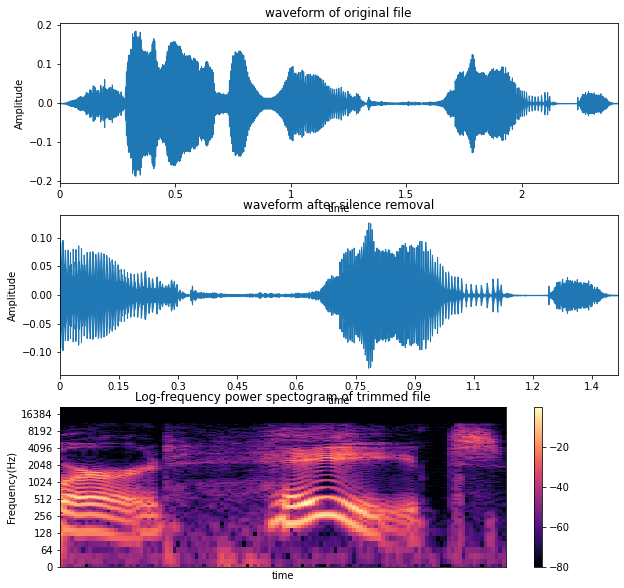

In [12]:
data, rate = librosa.load(df['path'][0],sr = Fs)
threshold = 45
data_trim = endpoint(data, threshold)

In [13]:
ipd.Audio(data, rate=rate)

In [ ]:
ipd.Audio(data_trim, rate=rate)

# **Features**

In [14]:
def feature(path):
  # Frame size = 20ms
  #Window Size = 30ms
  Fs = 44100;
  frame_length = int(Fs*.02);
  n_fft = int(Fs*.03);
  hop_length = n_fft//2;
  threshold = 45;
  data, rate = librosa.load(ravdess_db['path'][0],sr = Fs)
  data_trim, index = librosa.effects.trim(data[Fs:], top_db=threshold, frame_length=frame_length) # Removing silence from endpoints
  data_pre = librosa.effects.preemphasis(data_trim,coef=0.95) # Pre-emphasis
  # Feature extraction
  mfcc = librosa.feature.mfcc(data_pre,sr=Fs,n_mfcc=13,hop_length=hop_length,window='hamming',n_fft = n_fft) 
  delta_1 = librosa.feature.delta(mfcc,order=1)
  delta_2 = librosa.feature.delta(mfcc,order=2) 
  features  = np.vstack((mfcc,delta_1,delta_2))
  # Set length of features to be 200
  if features.shape[1]<200:
    features = np.concatenate((features,features[:,0:(200-features.shape[1])]),axis = 1)
  return features

# **Training**

In [ ]:
'''df = pd.DataFrame(columns=['feature'])
d = []
for index,path in enumerate(ravdess_db['path'][0:10]):
  feat = feature(path)
  d.append(feat)'''
f = np.array(d)
print(f.shape)
